In [1]:
""" Notebook to introduce Data Augmentation Concept. 

Data Augmentation involves increasing the training data by manipulating data in Intelligent way. For ex.
Flipping an image in train data horizontally or zooming it in or out, etc.

It also helps in preventing Overfitting of Data. In this NB, "CatsVsDogs" dataset is used which contain images of
cats and dogs and we are training a NN to differentiate between them. """

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #This ones new
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# We load the dataset externally
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip',origin=_URL,extract=True)

In [3]:
base_dir = os.path.join(os.path.dirname(zip_dir),'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'validation')

In [4]:
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
val_cats_dir = os.path.join(val_dir,'cats')
val_dogs_dir = os.path.join(val_dir,'dogs')

In [5]:
# Number of cats & dogs in training and validation images
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))
total_tr = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print(total_tr,total_val)

2000 1000


In [6]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [7]:
# Function to plot the images
def plot_image(images_arr):
    fig,axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(images_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Training Image Data Generator
image_gen_tr = ImageDataGenerator(rescale = 1./255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip = True,
                              fill_mode='nearest')

# Creating Training Batches
train_data_gen = image_gen_tr.flow_from_directory(batch_size = BATCH_SIZE,
                          shuffle=True,
                          directory=train_dir,
                          target_size=(IMG_SHAPE,IMG_SHAPE))

# Validation Image Data Generator
image_gen_val = ImageDataGenerator(rescale = 1./255)

# Creating Validation Batches
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory = val_dir,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


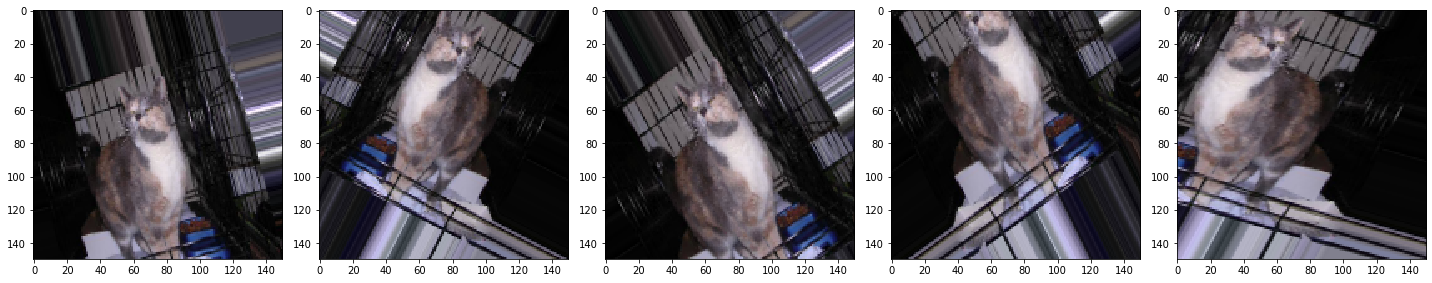

In [8]:
aug_images = [train_data_gen[0][0][0] for i in range(5)]
plot_image(aug_images)

In [13]:
# Creating model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)), # 3 for RGB image
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
# In dropout, randomly some neurons in the layer are shut off completely to make sure that all neurons train properly
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax') #Sigmoid can also be used instead of Softmax but unit is then 1 for 2 classes
    ])

In [14]:
model.compile(loss='sparse_categorical_crossentropy', #Loss function changes if last layer is activated as Sigmoid
             metrics=['accuracy'],
             optimizer='adam')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [16]:
epochs = 1
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(total_tr/float(BATCH_SIZE))),
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(total_val/float(BATCH_SIZE)))
)

ValueError: Shape mismatch: The shape of labels (received (200,)) should equal the shape of logits except for the last dimension (received (4900, 2)).